# Time Series Forecasting with Machine Learning techniques

# 1. Understanding TOAR data

[TOAR Data Infrastructure](https://toar-data.fz-juelich.de/) uses a REST API based data provisioning mechanism which is used to illustrate long range timeseries forecasting tasks using machine learning techniques on air quality data.

Initially preliminary analysis is to be performed on the data and subsequently appropriate pre-processing approaches are determined to better forecast future values of the pollutant concentration.

The task also iteratively introduces how performance and methodology has evolved systematically from classical ML techniques to recurrent neural networks in forecasting univariate timeseries. Illustrating the advantages and shorcomings in the approach.

Finally to demostrate the state of the art capabilities of architectures like transformers which can be leveraged to do multi variate forecasting utilising known past meterological data.

> Please note: In case of runtime loss or a need to run any segmented sections of the code make sure to run all the housekeeping cells before it






## Initial Setup and Data download
> This section downloads example data from TOAR for 5 stations in Germany. Refer to [TOAR Quick UserGuide](https://toar-data.fz-juelich.de/sphinx/TOAR_UG_Vol02_Quick_Start/build/html/examples.html) examples to better understand data structuring in TOAR that is used in the below snippet to download examples.

### Housekeeping: Initial setup, declarations and method definitions

In [ ]:
# Most notebook servers like google collab should have these packages pre-installed
# In such cases this is a sanity check
!pip install pandas numpy requests

In [ ]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# Global constants
TIMESERIES_DATA_DIR = "/content/timeseries_data/"
TIMESERIES_CSV_DIR = os.path.join(TIMESERIES_DATA_DIR, "toar_csv_timeseries")
TIMESERIES_ID_FILE = os.path.join(TIMESERIES_DATA_DIR, "timeseriesIDs.json")
MIN_FILE_SIZE_BYTES = 100
group_columns = ['station_code', 'latitude', 'longitude']

os.makedirs(TIMESERIES_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_CSV_DIR, exist_ok=True)

Custom range selection for experiments

station codes in the example snippet below are checked for a common range for the chosen variables, however if you prefer to experiment with ranges you might want to check using [Search API](https://toar-data.fz-juelich.de/api/v2/#search-combined-endpoint-of-stations-and-timeseries) for the date range for which data is available for a particular variable, station and source combination. As the TOAR is observational data provided via different contributing sources and has vast missing data.

In [ ]:
# 5 German stations with good distribution o3 variable observations
station_codes = ["DENW094", "DEBW073","DEBB029","DEBE051","DEHE020"]
variable_columns = ["no2", "temp", "o3", "no", "press"]

Below methods each have appropriate documentation and comments to illustrate the logical flow *(they are placed with enough safeguards against both the API and optimized to avoid re-downloads when interupted during partial downloads to accomodate any loss of runtime on platforms like google colab)* and briefly described here for ease of use
>

In [ ]:
def load_existing_timeseries_ids():
    """
    Load existing timeseries IDs from a JSON file.

    Returns:
        dict: A dictionary containing stored timeseries metadata.
    """
    return json.load(open(TIMESERIES_ID_FILE, 'r')) if os.path.exists(TIMESERIES_ID_FILE) else {}

def save_timeseries_ids(timeseries_data):
    """
    Save timeseries metadata to a JSON file.

    Args:
        timeseries_data (dict): A dictionary containing timeseries metadata.
    """
    json.dump(timeseries_data, open(TIMESERIES_ID_FILE, 'w'), indent=4)

def fetch_timeseries_data(station_codes, existing_timeseries, variable_columns):
    """
    Fetch timeseries metadata for given station codes, filtering by specified variables.

    Args:
        station_codes (list): List of station codes to fetch data for.
        existing_timeseries (dict): Dictionary of previously fetched timeseries metadata.
        variable_columns (list): List of variable names to retain.

    Returns:
        dict: Updated dictionary containing filtered timeseries metadata.
    """
    base_url = "http://toar-data.fz-juelich.de/api/v2/search/?codes="
    unique_entries = existing_timeseries.copy()
    processed_station_codes = {details['station_code'] for details in existing_timeseries.values()}

    for code in station_codes:
        if code in processed_station_codes:
            print(f"\t\tStation {code} is already processed, skipping.")
            continue

        response = requests.get(base_url + code, timeout=1000)
        if response.status_code == 200:
            for entry in response.json():
                if (variable_name := entry.get('variable', {}).get('name')) in variable_columns:
                    timeseries_id = entry.get('id')
                    if timeseries_id not in unique_entries:
                        unique_entries[timeseries_id] = {
                            'data_start_date': entry.get('data_start_date'),
                            'data_end_date': entry.get('data_end_date'),
                            'variable_name': variable_name,
                            'station_code': code,
                            'latitude': entry.get('station', {}).get('coordinates', {}).get('lat'),
                            'longitude': entry.get('station', {}).get('coordinates', {}).get('lng'),
                        }
        else:
            print(f"\t\tFailed to fetch data for station {code}. Status code: {response.status_code}")
    return unique_entries

def pivot_handle(dfs, metadata_columns, variable_columns):
    """
    Pivot and structure the timeseries dataframe for sequential data analysis.

    Args:
        dfs (pd.DataFrame): Dataframe containing timeseries data.
        metadata_columns (list): List of metadata column names.
        variable_columns (list): List of variable names to include.

    Returns:
        pd.DataFrame: Processed dataframe with pivoted structure.
    """
    dfs = dfs[dfs['variable_name'].isin(variable_columns)]
    pivot_df = dfs.pivot(index='datetime', columns='variable_name', values='value').reset_index()
    return dfs[metadata_columns].drop_duplicates(subset=['datetime']).merge(pivot_df, on='datetime', how='left')

def download_csv_data(timeseries_data, variable_columns):
    """
    Download and process CSV data for each timeseries ID.

    Args:
        timeseries_data (dict): Dictionary containing timeseries metadata.
        variable_columns (list): List of variable names to process.

    Returns:
        pd.DataFrame: Combined dataframe of all timeseries data.
    """
    dataframes = []
    metadata_columns = ['datetime', 'station_code', 'latitude', 'longitude']

    for ts_id, details in timeseries_data.items():
        csv_path = os.path.join(TIMESERIES_CSV_DIR, f"{ts_id}.csv")

        if os.path.exists(csv_path) and os.path.getsize(csv_path) > MIN_FILE_SIZE_BYTES:
            print(f"\tCSV already exists for timeseries ID {ts_id}, skipping download.")
        else:
            print(f"\tDownloading data for timeseries ID {ts_id}")
            url = f"http://toar-data.fz-juelich.de/api/v2/data/timeseries/{ts_id}?format=csv"
            try:
                response = requests.get(url, stream=True, timeout=1000)
                response.raise_for_status()
                with open(csv_path, 'wb') as file:
                    file.writelines(response.iter_content(chunk_size=8192))
                print(f"\t\tRaw data CSV of {ts_id} saved: {csv_path}")
            except requests.exceptions.RequestException as e:
                print(f"\t\tFailed to download data for timeseries ID {ts_id}. Error: {e}")
                continue

        try:
            df = pd.read_csv(csv_path, skiprows=lambda i: i < next(i for i, line in enumerate(open(csv_path)) if line.startswith('datetime')), low_memory=False)
            df['datetime'] = pd.to_datetime(df['datetime'], format='mixed')
            df[['variable_name', 'station_code', 'latitude', 'longitude']] = details['variable_name'], details['station_code'], details['latitude'], details['longitude']
            print(f"Dataframe for timeseries ID {ts_id} loaded successfully with shape {df.shape}")
            dataframes.append(pivot_handle(df, metadata_columns, variable_columns))
        except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
            print(f"\tError processing CSV for timeseries ID {ts_id}: {e}")
            continue

    return pd.concat(dataframes, ignore_index=True).sort_values(by=['station_code', 'datetime']) if dataframes else pd.DataFrame()

### Download via REST API

In [ ]:
# Load existing timeseries IDs from json to skip calls to TOAR
existing_timeseries = load_existing_timeseries_ids()

timeseries_data = fetch_timeseries_data(station_codes, existing_timeseries,variable_columns)
print(f"\t Number of time series meta data fetched : {len(timeseries_data)}")

# save existing timeseries IDs as json to reduce calls to TOAR in future
save_timeseries_ids(timeseries_data)

dataframes = download_csv_data(timeseries_data,variable_columns)
print(f"\t Total dataFrames processed : {len(dataframes)} and shape of first dataframe {dataframes.shape}.")

dataframes.head()

	 Number of time series meta data fetched : 24
		Raw data CSV of 73 saved: /content/timeseries_data/toar_csv_timeseries/73.csv
Dataframe for timeseries ID 73 loaded successfully with shape (209293, 9)
		Raw data CSV of 74 saved: /content/timeseries_data/toar_csv_timeseries/74.csv
Dataframe for timeseries ID 74 loaded successfully with shape (208350, 9)
		Raw data CSV of 75 saved: /content/timeseries_data/toar_csv_timeseries/75.csv
Dataframe for timeseries ID 75 loaded successfully with shape (206829, 9)
		Raw data CSV of 76 saved: /content/timeseries_data/toar_csv_timeseries/76.csv
Dataframe for timeseries ID 76 loaded successfully with shape (244514, 9)
		Raw data CSV of 80 saved: /content/timeseries_data/toar_csv_timeseries/80.csv
Dataframe for timeseries ID 80 loaded successfully with shape (160608, 9)
		Raw data CSV of 18645 saved: /content/timeseries_data/toar_csv_timeseries/18645.csv
Dataframe for timeseries ID 18645 loaded successfully with shape (209057, 9)
		Raw data CSV of 19

,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
1816320,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,18.54588,NaN,NaN,NaN,NaN
2079966,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,NaN,6.79861,NaN,NaN,NaN
2345500,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,NaN,NaN,1.60364,NaN,NaN
1816321,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,20.55084,NaN,NaN,NaN,NaN
2079967,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,NaN,3.66079,NaN,NaN,NaN


As the TOAR is observational data provided via different contributing sources and has vast missing data, we expect the NAs despite finding a common date range and need to check how many missing values (NAs) there are for each variable.

In [ ]:
dataframes.shape

(4779984, 9)

In [ ]:
dataframes.isna().sum()

,0
datetime,0
station_code,0
latitude,0
longitude,0
o3,3475068
no2,3466521
no,3408513
temp,4205745
press,4564089


## Data handling (observational gaps)

Once we know that, we can figure out the best way to fill in the gaps, like using interpolation or making the data more consistent. In our case as the data is towards pollutant concentration and data is hourly, we can safely fill a consecutive 6 hour window without compromising the quality of the data

In [ ]:
import numpy as np
def fill_six_nans(group):
    """
    Fills up to six consecutive NaN values in a given pandas Series using linear interpolation
    if the NaNs are surrounded by valid values. If the NaNs are at the start, they are replaced
    with zeros, and if they are at the end, they are filled with the last known value.

    Args:
        group (pd.Series): The input Series with potential NaN values.

    Returns:
        pd.Series: A Series where up to six consecutive NaNs are interpolated, and longer NaN
        sequences are partially filled while preserving the original index.
    """
    values = group.to_numpy()
    i = 0
    while i < len(values):
        if np.isnan(values[i]):
            start = i
            while i < len(values) and np.isnan(values[i]):
                i += 1
            end = min(i, start + 6)  # Limit to filling only 6 NaNs

            if start > 0 and i < len(values):  # NaNs in the middle
                fill_values = np.linspace(values[start - 1], values[i], end - start + 2)[1:-1]
            elif start == 0:  # NaNs at the start
                fill_values = [0] * (end - start)
            elif i >= len(values):  # NaNs at the end
                fill_values = [values[start - 1]] * (end - start)
            values[start:end] = fill_values
        else:
            i += 1
    return pd.Series(values, index=group.index)

In [ ]:
dataframes[variable_columns] = dataframes.groupby(group_columns)[variable_columns].transform(fill_six_nans)
dataframes.isna().sum()

,0
datetime,0
station_code,0
latitude,0
longitude,0
o3,145135
no2,97314
no,103168
temp,2561353
press,3792650


Now rest of the Nas can be dropped as that station might not have data collected in the time period and the data needs to be normalized.

In [ ]:
dataframes = dataframes.dropna()
dataframes.isna().sum()

,0
datetime,0
station_code,0
latitude,0
longitude,0
o3,0
no2,0
no,0
temp,0
press,0


## Data Preprocessing (Normalization)

the snippet below uses standard Z normalization (this is a simple snippet alternatively other approaches could also be used as desired)


In [ ]:
def standard_scaler(df, columns):
    """
    Standardize the specified columns of a DataFrame by subtracting the mean
    and dividing by the standard deviation (Z-score normalization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to be normalized.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """
    df_scaled = df.copy()
    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = (df_scaled[col] - mean) / std
    return df_scaled

In [ ]:
dataframes = standard_scaler(dataframes, variable_columns)
dataframes.head()

,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
1816320,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.420542,-1.191141,-0.371676,-1.435804,-87.095184
2079966,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.374917,-0.122081,-0.371676,-1.435804,-87.095184
2345500,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.329291,-0.286552,-0.191161,-1.435804,-87.095184
1816321,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,-0.283666,-0.451023,-0.191161,-1.435804,-87.095184
2079967,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,-0.260853,-0.615493,-0.191161,-1.435804,-87.095184


## Staged data loading (Housekeeping)

If you are happy with the normalization before we proceed with any analysis now the normalized data can be locally saved to reload when needed (In case of runtime losses) to continue with ML experiments rather than re-downloading and normalizing again.

In [ ]:
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), index=False)

Below cell can be used to reload data if using an open source notebook servers like google colab and the if the usage limit is reached or for other issues

In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1ohReYdUgtBFogeAmxghPo3_Qa9RnzxSh/view?usp=drive_link
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
dataframes.head()

,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
0,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.420542,-1.191141,-0.371676,-1.435804,-87.095184
1,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.374917,-0.122081,-0.371676,-1.435804,-87.095184
2,1994-01-01 00:00:00+00:00,DEBB029,53.064262,14.285139,-0.329291,-0.286552,-0.191161,-1.435804,-87.095184
3,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,-0.283666,-0.451023,-0.191161,-1.435804,-87.095184
4,1994-01-01 01:00:00+00:00,DEBB029,53.064262,14.285139,-0.260853,-0.615493,-0.191161,-1.435804,-87.095184


## Data Pre-processing and analysis
The data can now be analysed for basic statistical tendencies or measures and then timeseries specific trends and anamolies

### Statistical Analysis

The data can now be analysed for basic statistical tendencies or measures like (note standard measures are indicated here, but you can run custom measures as well)

In [ ]:
stats = ['min', 'max', 'mean', 'sum', 'std', 'var', 'median','prod','nunique',
    ('5th_percentile', lambda x: x.quantile(0.05)),
    ('10th_percentile', lambda x: x.quantile(0.10)),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('50th_percentile', lambda x: x.quantile(0.50)), #(median)
    ('75th_percentile', lambda x: x.quantile(0.75))]
agg_dict = {col: stats for col in variable_columns}
dataframes.groupby('station_code').agg(agg_dict)

no2                                                      \
                   min        max      mean        sum       std       var   
station_code                                                                 
DEBB029      -1.191141  -0.122081 -0.556101  -3.336608  0.372000  0.138384   
DEBE051      -1.191141  -1.191141 -1.191141  -7.146847  0.000000  0.000000   
DEBW073      -1.191141  -1.191141 -1.191141  -7.146847  0.000000  0.000000   
DEHE020       2.920628   3.928012  3.527114  21.162686  0.401556  0.161247   
DENW094      -1.591216  11.596462 -0.000005  -3.532384  0.999949  0.999899   

                                                            ...     press  \
                median         prod nunique 5th_percentile  ...       std   
station_code                                                ...             
DEBB029      -0.533258     0.007754       6      -1.060935  ...  0.000000   
DEBE051      -1.191141     2.856140       1      -1.191141  ...  0.000000   
DEBW073      -1.191141     2.856140       1      -1.191141  ...  0.000000   
DEHE020       3.599070  1861.506940       6       2.992584  ...  0.000000   
DENW094      -0.303007    -0.000000  276842      -0.994525  ...  0.860825   

                                                                        \
                   var     median          prod nunique 5th_percentile   
station_code                                                             
DEBB029       0.000000 -87.095184  4.364805e+11       1     -87.095184   
DEBE051       0.000000 -87.095184  4.364805e+11       1     -87.095184   
DEBW073       0.000000 -87.095184  4.364805e+11       1     -87.095184   
DEHE020       0.000000 -87.095184  4.364805e+11       1     -87.095184   
DENW094       0.741019   0.064989  0.000000e+00  173348      -1.493329   

                                                                              
             10th_percentile 25th_percentile 50th_percentile 75th_percentile  
station_code                                                                  
DEBB029           -87.095184      -87.095184      -87.095184      -87.095184  
DEBE051           -87.095184      -87.095184      -87.095184      -87.095184  
DEBW073           -87.095184      -87.095184      -87.095184      -87.095184  
DEHE020           -87.095184      -87.095184      -87.095184      -87.095184  
DENW094            -1.092819       -0.474303        0.064989        0.566866  

[5 rows x 70 columns]

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### **Timeseries Data Analysis and Anomaly Detection**
Since we know the data is a timeseries, we can analyse for seasonality, trends, and anomalies. such as:
- **Temporal Seasonality:** Decomposing the time series into trend, seasonality, and residuals.
- **Rolling Statistics:** Checking for stationarity.
- **Autocorrelation (ACF, PACF):** Identifying patterns in the data.
- **Anomaly Detection:** Using Z-score and visualizing anamolies.

#### Housekeeping: Initial setup and declarations

In [ ]:
!pip install seaborn matplotlib statsmodels ## dependent on your notebook setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
station_sample = 'DENW094'
variable_sample = 'o3'
# Filter data for the selected samples
df_station = dataframes[dataframes["station_code"] == station_sample]

#### Visualizing initial data before trends
 Select a station and variable for analysis o3 is picked here to identify seasonalities for comparison with multivariate but feel free to experiment with other variables and analyse the trends

Plot the original timeseries


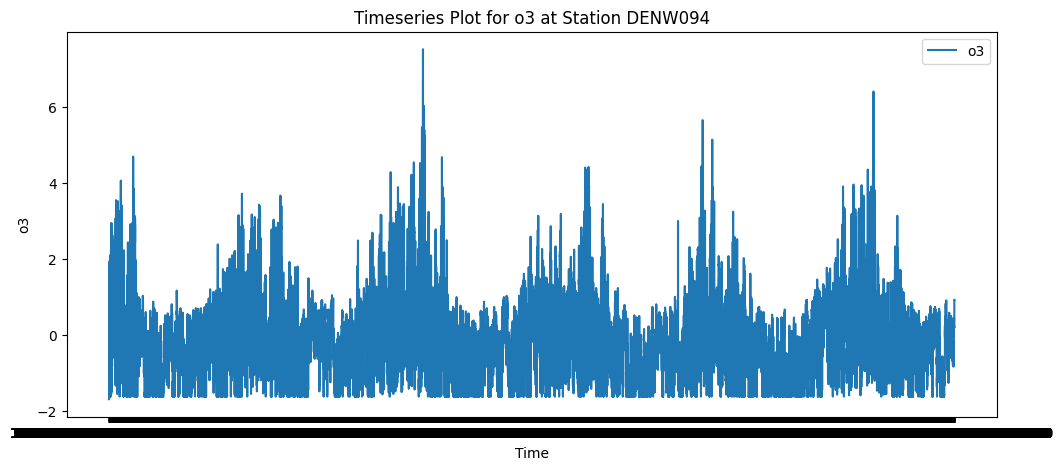

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample)
plt.xlabel("Time")
plt.ylabel(variable_sample)
plt.title(f"Timeseries Plot for {variable_sample} at Station {station_sample}")
plt.legend()
plt.show()

#### Temporal Seasonality
Here is a simple sample seasonal decomposition, you can experiment with modifying the period and other seasonalities

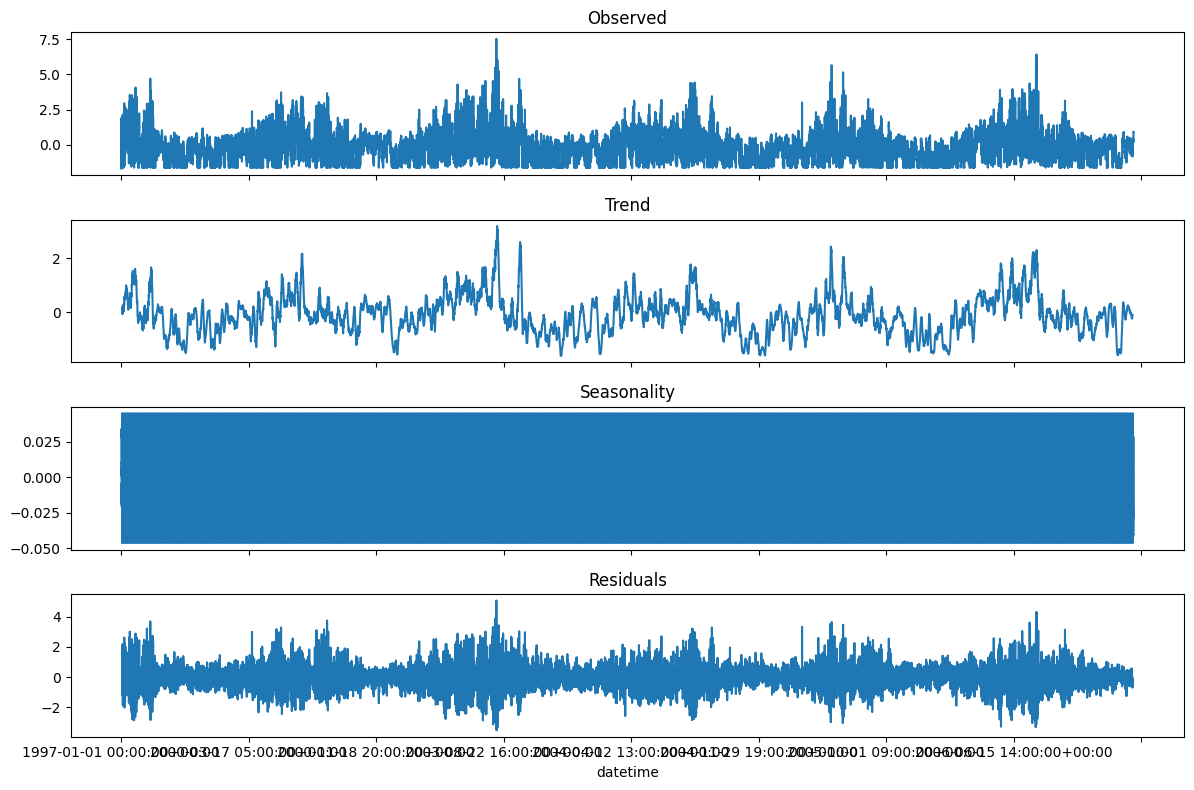

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(df_station.set_index("datetime")[variable_sample], period=365, model='additive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")
plt.tight_layout()
plt.show()

#### Rolling Statistics Analysis

Below is a sample function using adfuller method from stats_model package used for visualizing stationarity in the o3 of the sample station

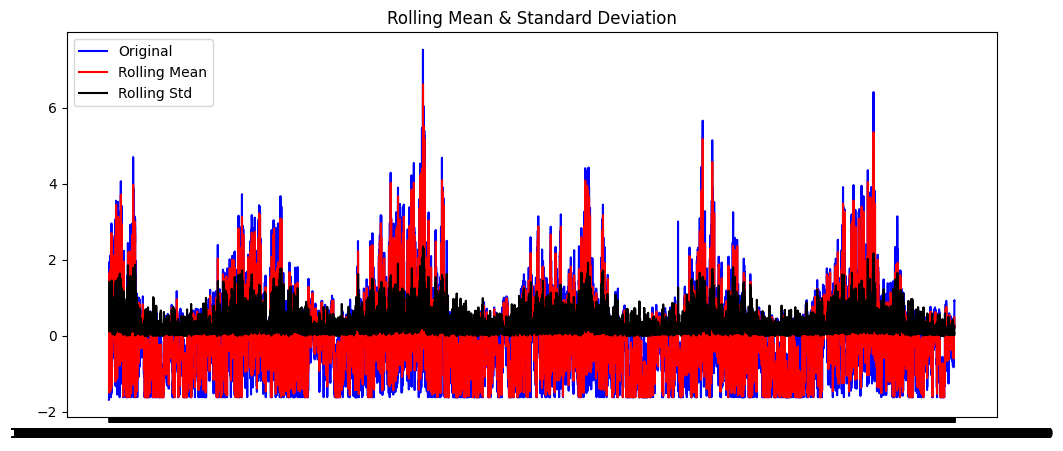

In [ ]:
def plot_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    plt.figure(figsize=(12,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()


plot_stationarity(df_station.set_index("datetime")[variable_sample])

Below snippet uses ADF (Augmented Dickey-Fuller) test checks if a time series is stationary (constant mean and variance over time). In Moving Average models, p (AutoRegressive lags), d (number of differences for stationarity), and q (Moving Average lags) help capture trends and fluctuations—stationarity ensures that past patterns remain predictive for future values. AIC (Akaike Information Criterion) measures the goodness of fit of a model while penalizing complexity. In MA models, it helps select the best combination of p, d, q by balancing model accuracy and simplicity—lower AIC values indicate a better model as illustrated later on.

In [ ]:
adf_test = adfuller(df_station.set_index("datetime")[variable_sample].dropna(), autolag='AIC')
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")
print("Critical Values:", adf_test[4])
print("Stationary" if adf_test[1] < 0.05 else "Not Stationary")

ADF Test Statistic: -18.55468444611919
P-Value: 2.0905731126849794e-30
Critical Values: {'1%': -3.4303829526353926, '5%': -2.861554564628198, '10%': -2.566777752228064}
Stationary


If we start with a difference of 0 we can determine optimal differencing (d) conditioned on p

In [ ]:
d = 0
while adf_test[1] > 0.05 and d < 3:  # Limit differencing to prevent over-differencing
    series = series.diff().dropna()
    adf_test = adfuller(series, autolag="AIC")
    d += 1

# Auto-log can pick a good enough p and q
best_pq = adf_test[2]
p, q = best_pq, best_pq

#### Correlation analysis

A simple *auto correlation* on the variable would indicate trend repetion ability of the time series in itself

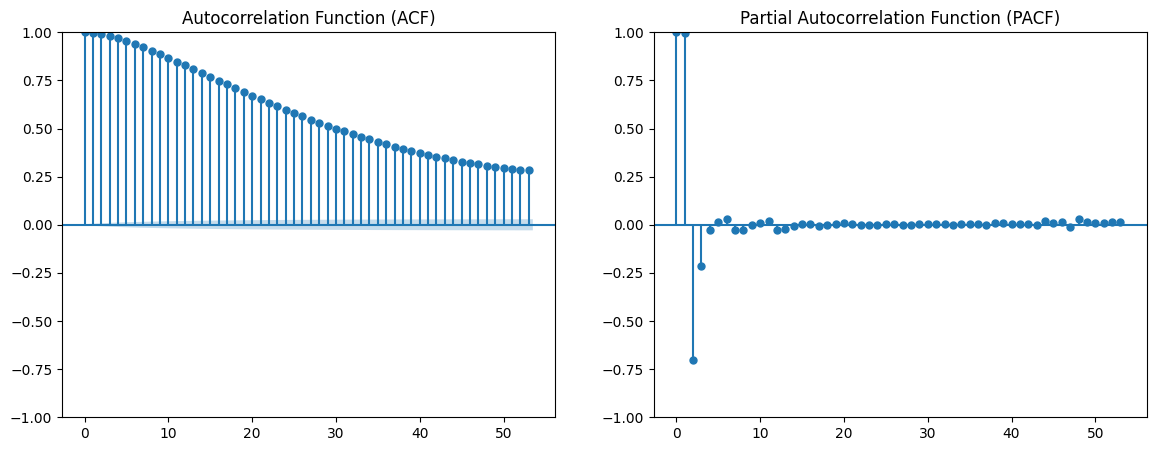

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[0])
plot_pacf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[1])
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

#### Analomaly detection using Z-score

Normalized data over a chosen threshold (say 3) is visualized


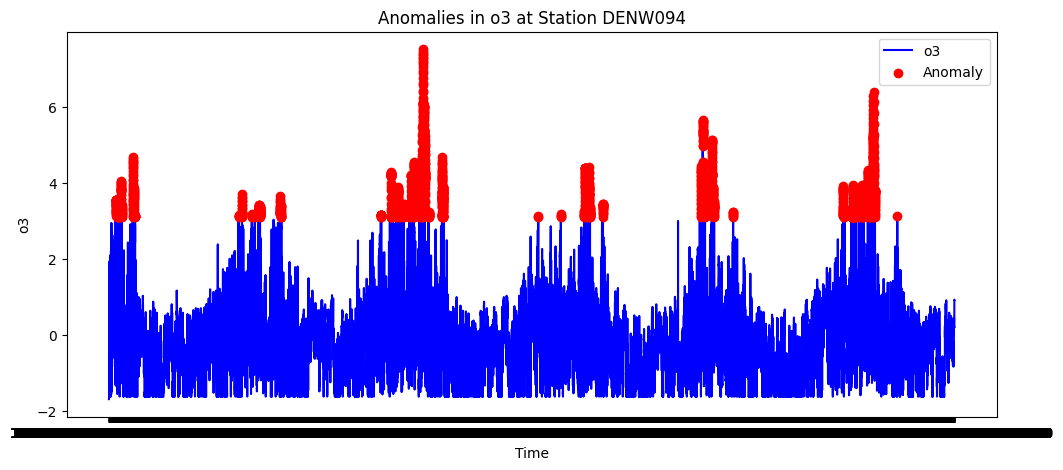

In [ ]:
from scipy.stats import zscore

# Compute Z-scores
df_station = df_station.copy()
df_station.loc[:, "zscore"] = zscore(df_station[variable_sample], nan_policy='omit')

# Sample threshold for anomalies (|Z-score| > 3)
threshold = 3
df_anomalies = df_station[np.abs(df_station["zscore"]) > threshold]

# Plot anomalies
plt.figure(figsize=(12, 5))
plt.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample, color='blue')
plt.scatter(df_anomalies["datetime"], df_anomalies[variable_sample], color='red', label="Anomaly", zorder=3)
plt.xlabel("Time")
plt.ylabel(variable_sample)
plt.title(f"Anomalies in {variable_sample} at Station {station_sample}")
plt.legend()
plt.show()


The values of anamolies above chosen sample 4 are listed below the idea is now for ML approaches to not just capture the above trends also handle the challenge of finding any underlying patterns to generalize well to accoung for these extremities.

In [ ]:
from IPython.display import display

# Display the detected anomalies
print("Anomalies Detected:")
display(df_anomalies)

Anomalies Detected:


,datetime,station_code,latitude,longitude,o3,no2,no,temp,press,zscore
1671,1999-07-25 12:00:00+00:00,DENW094,50.754704,6.093923,3.145083,-0.321796,-0.010646,2.126446,0.399059,3.050178
1672,1999-07-25 13:00:00+00:00,DENW094,50.754704,6.093923,3.206678,-0.374661,-0.010646,2.126446,0.384433,3.108202
1673,1999-07-25 13:00:00+00:00,DENW094,50.754704,6.093923,3.258006,-0.427527,-0.010646,2.126446,0.369806,3.156556
1674,1999-07-25 13:00:00+00:00,DENW094,50.754704,6.093923,3.309335,-0.480392,-0.010646,2.153331,0.355180,3.204909
1675,1999-07-25 14:00:00+00:00,DENW094,50.754704,6.093923,3.388039,-0.467470,-0.010646,2.233986,0.328853,3.279051
...,...,...,...,...,...,...,...,...,...,...
179878,2006-07-29 17:00:00+00:00,DENW094,50.754704,6.093923,3.391461,-0.656611,-0.010646,2.220543,-0.478516,3.282275
179879,2006-07-29 18:00:00+00:00,DENW094,50.754704,6.093923,3.309335,-0.615493,-0.010646,2.180216,-0.478516,3.204909
179880,2006-07-29 18:00:00+00:00,DENW094,50.754704,6.093923,3.203256,-0.574376,-0.010646,2.139888,-0.478516,3.104978
179881,2006-07-29 18:00:00+00:00,DENW094,50.754704,6.093923,3.097177,-0.467470,-0.010646,2.099561,-0.478516,3.005048


# 2. Time Series Forecasting


> Add blockquote



### Sample creation (Housekeeping)


> Samples are needed for sequence models and transformer models for input



In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

In [ ]:
# Function to create time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    for i in range(n_past, len(data) - n_future):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future])
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

80/20 train/test split chosen for illustration

In [ ]:
X, y = create_sequences(dataframes[variable_columns].values)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

context_window = 24
prediction_horizon = 6 # Predict 6 steps for each variable from 24 past values
scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (562310, 24, 5), y_train shape: (562310, 6, 5)
X_test shape: (140578, 24, 5), y_test shape: (140578, 6, 5)


### Forecasting with MA models: Arima


> Add blockquote



As we had the adfuller earlier to determine p,d,q for MA models, we can try to visualize the initial performance of ARIMA with that

In [ ]:
from decimal import Decimal
arima_predictions = {}
# p = 1
# d = 1
# q = 1

The below snipped does a simple univariate ARIMA training and the
(p, d, q) values can be tuned for better forecasting next 6 hours using past 24 hours past date, you may want to try cuML ARIMA, prophet etc.. which might need dedicated compute resources

In [ ]:
for col in variable_columns:
    # p, d, q = 1, 1, 1
    print(f"p,d,q values for {col}: p={p}, d={d}, q={q}")
    train_data = dataframes[col].dropna()
    train_data = train_data[-1000:]  # Use only the last 1000 points due to notebook limit

    # order = tune_arima(train_data, d, p, q)
    # print(f"Tuned values for {col}:  (p,d,q)={order}")
    order = (p, d, q)
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    print(model_fit.summary())

    forecast = model_fit.forecast(steps=prediction_horizon)
    arima_predictions[col] = forecast

arima_df = pd.DataFrame(arima_predictions, index=pd.date_range(dataframes.index[-1], periods=prediction_horizon, freq="h"))
print(arima_df)


p,d,q values for no2: p=1, d=1, q=1


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    no2   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3078.650
Date:                Sun, 16 Mar 2025   AIC                          -6151.301
Time:                        19:34:09   BIC                          -6136.581
Sample:                             0   HQIC                         -6145.706
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7806      0.014     57.486      0.000       0.754       0.807
ma.L1          0.0700      0.038      1.845      0.065      -0.004       0.144
sigma2         0.0001   1.34e-06     91.620      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3671.854
Date:                Sun, 16 Mar 2025   AIC                          -7337.708
Time:                        19:34:09   BIC                          -7322.988
Sample:                             0   HQIC                         -7332.113
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8394      0.008    107.115      0.000       0.824       0.855
ma.L1          0.0175      0.011      1.536      0.124      -0.005       0.040
sigma2      3.749e-05   4.35e-07     86.246      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

                               SARIMAX Results                                
Dep. Variable:                     no   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3415.532
Date:                Sun, 16 Mar 2025   AIC                          -6825.065
Time:                        19:34:10   BIC                          -6810.344
Sample:                             0   HQIC                         -6819.470
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6592      0.008     82.775      0.000       0.644       0.675
ma.L1          0.1483      0.021      6.940      0.000       0.106       0.190
sigma2       6.27e-05   3.64e-07    172.470      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

                               SARIMAX Results                                
Dep. Variable:                  press   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3888.400
Date:                Sun, 16 Mar 2025   AIC                          -7770.800
Time:                        19:34:10   BIC                          -7756.080
Sample:                             0   HQIC                         -7765.205
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9046      0.012     74.395      0.000       0.881       0.928
ma.L1         -0.1675      0.026     -6.377      0.000      -0.219      -0.116
sigma2       2.43e-05   3.85e-07     63.179      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


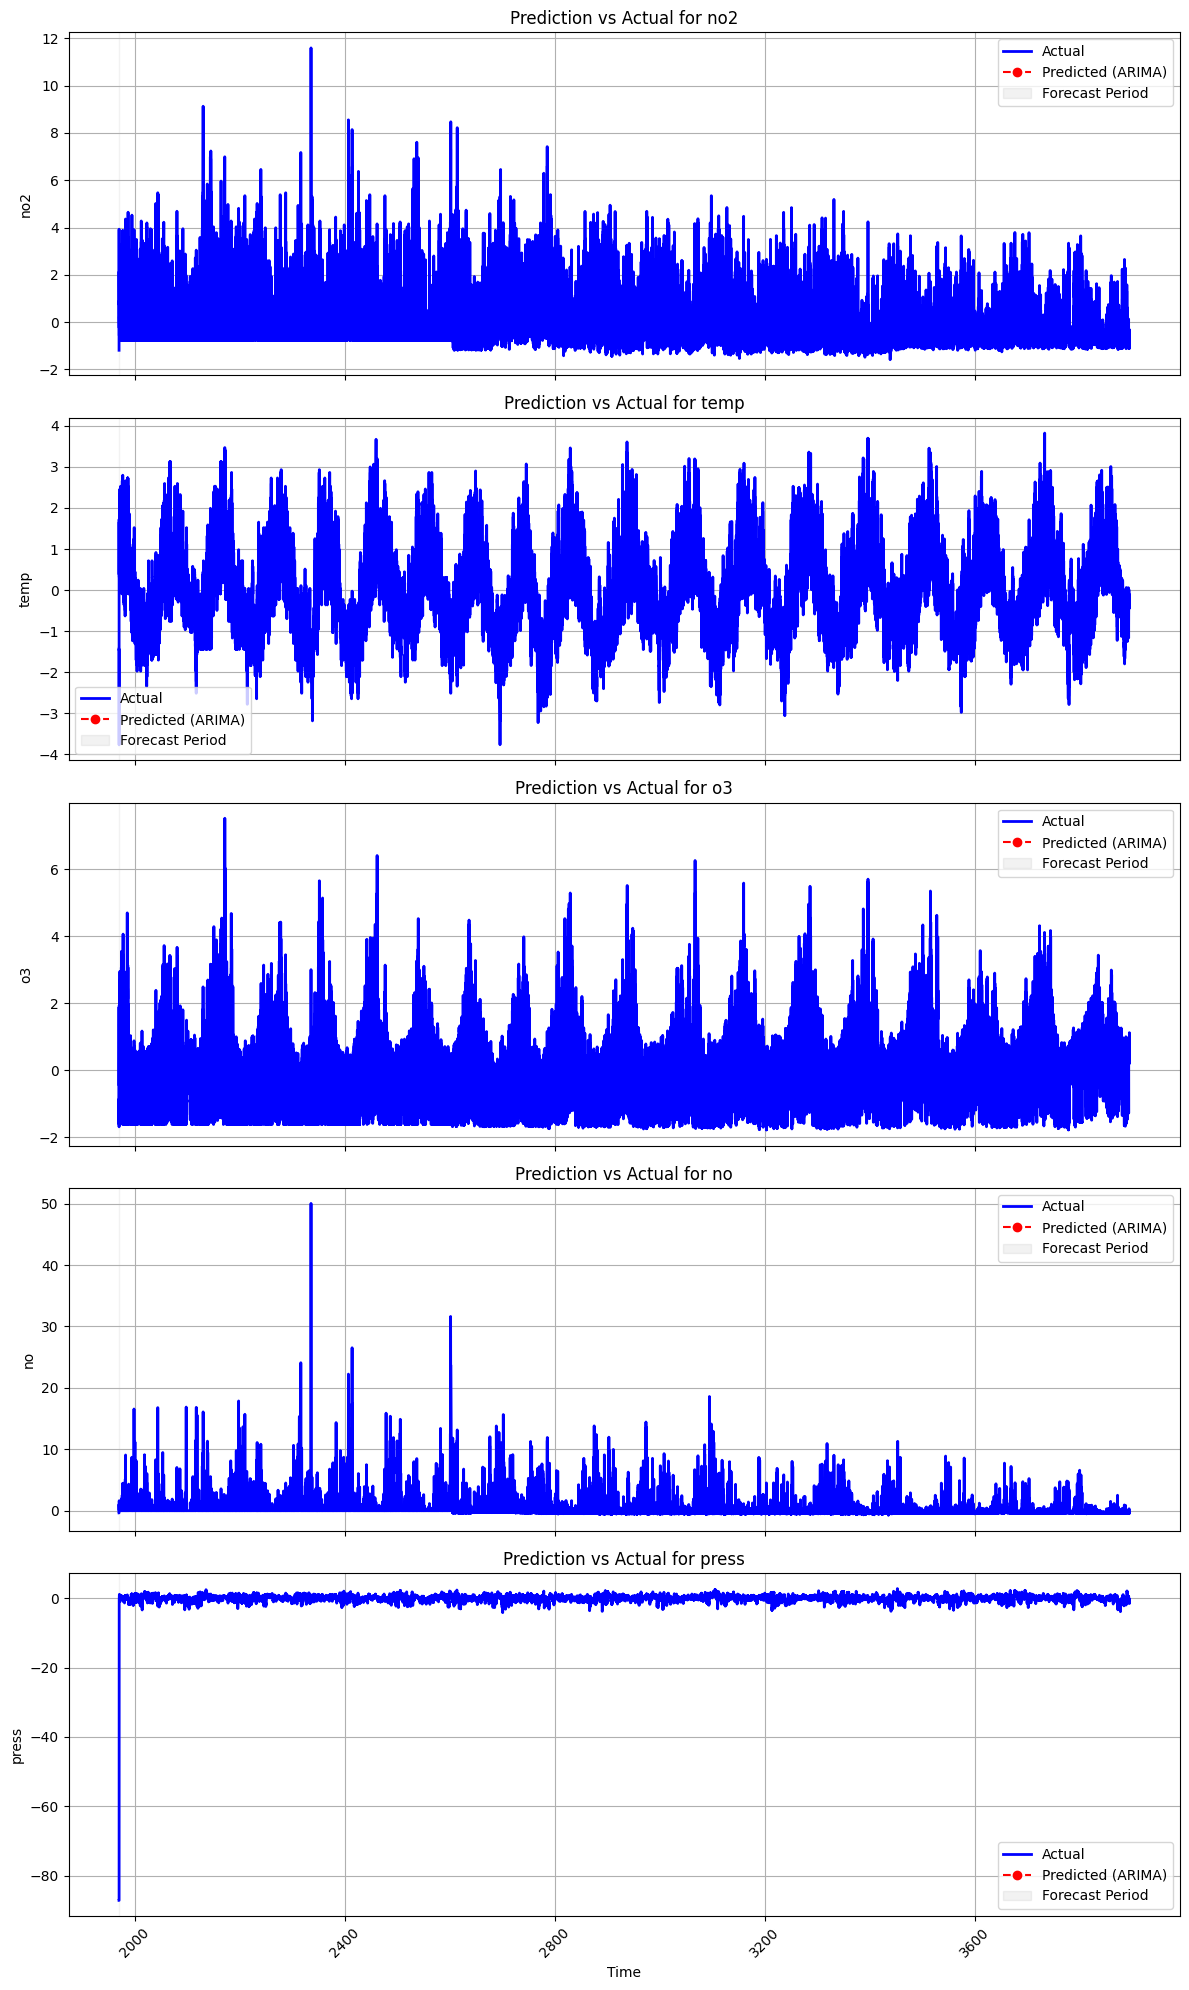

In [ ]:
import matplotlib.pyplot as plt

num_vars = len(variable_columns)
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 4 * num_vars), sharex=True)

if num_vars == 1:
    axes = [axes]

# Plot each variable separately
for i, col in enumerate(variable_columns):
    ax = axes[i]

    ax.plot(dataframes.index, dataframes[col], label="Actual", color="blue", linewidth=2)
    ax.plot(arima_df.index, arima_df[col], label="Predicted (ARIMA)", color="red", linestyle="dashed", marker='o')

    # Highlight forecast period
    ax.axvspan(arima_df.index[0], arima_df.index[-1], color="gray", alpha=0.1, label="Forecast Period")

    ax.set_title(f"Prediction vs Actual for {col}")
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True)

plt.xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

You can use the below function and

In [ ]:
from itertools import product

def tune_arima(series, d, initial_p, initial_q):
    """
    Perform grid search for the best (p, q) given fixed differencing order d.

    Args:
        series (pd.Series): The time series data.
        d (int): Differencing order.
        initial_p (int): Initial p value.
        initial_q (int): Initial q value.

    Returns:
        tuple: Best (p, d, q) combination.
    """
    p_values = range(max(0, initial_p - 1), min(4, initial_p + 2))  # Search p ±1 range
    q_values = range(max(0, initial_q - 1), min(4, initial_q + 2))  # Search q ±1 range
    best_aic, best_order = float("inf"), None

    for p, q in product(p_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic, best_order = model_fit.aic, (p, d, q)
        except:
            continue  # Skip invalid models
    return best_order

### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation

In [ ]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

# Flatten input features
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # (samples, 24*5)
y_train_reshaped = y_train.reshape(X_train.shape[0], prediction_horizon * len(variable_columns))
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/1OBLsAElWT6BubRUtI3_cHTJVecrue5kG/view?usp=sharing
checkpoint_dir = "mlp_model_checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

num_variables = X_train.shape[2]
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
    print(f"\nTraining model for variable {var_idx + 1}/{num_variables}")

    X_train_single = X_train[:, :, var_idx]  # Shape: (562310, 24)
    y_train_single = y_train[:, :, var_idx]  # Shape: (562310, 6)
    X_test_single = X_test[:, :, var_idx]    # Shape: (140578, 24)

    y_train_single = y_train_single.reshape(y_train_single.shape[0], -1)

    # Model checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"mlp_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {var_idx + 1}")
        mlp_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {var_idx + 1}")

        # Build MLP model
        mlp_model = Sequential([
            Input(shape=(X_train_single.shape[1],)),  # 24 timesteps (context window)
            Dense(mlp_hidden_units[0], activation=activation_fn)
        ])

        for units in mlp_hidden_units[1:]:
            mlp_model.add(Dense(units, activation=activation_fn))

        mlp_model.add(Dense(y_train_single.shape[1]))  # 6 timesteps (pred horizon)
        mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train model
        training = mlp_model.fit(
            X_train_single, y_train_single,
            epochs=mlp_epochs, batch_size=mlp_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )
        training_histories[var_idx] = training.history

    y_pred_single = mlp_model.predict(X_test_single)
    mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], 6, 5)  # Shape: (samples, 6, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], 6, 1)



Training model for variable 1/5
Loading existing model for variable 1
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step



Training model for variable 2/5
Loading existing model for variable 2
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step



Training model for variable 3/5
Loading existing model for variable 3
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step



Training model for variable 4/5
Loading existing model for variable 4
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step



Training model for variable 5/5
Loading existing model for variable 5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [ ]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], 6, 5)
for var_idx in range(num_variables):
    y_test_single = y_test_reshaped[:, :, var_idx]
    y_pred_single = mlp_predictions[:, :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.9636
Variable temp:
RMSE: 0.9918
Variable o3:
RMSE: 0.9906
Variable no:
RMSE: 0.8255
Variable press:
RMSE: 0.9413


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


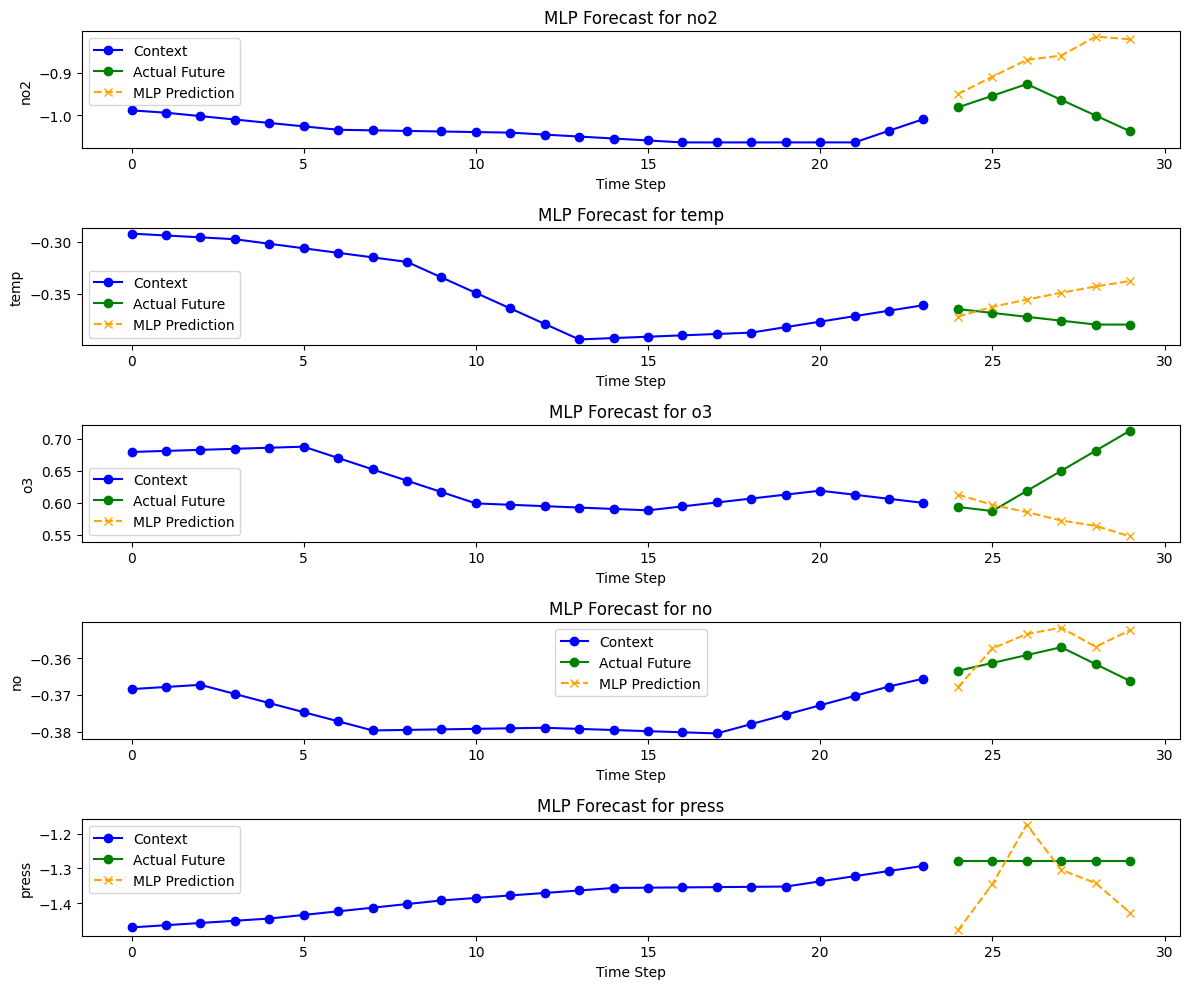

In [ ]:
plt.figure(figsize=(12, 10))

for variable_idx in range(num_variables):
    mlp_model = load_model(
        os.path.join(checkpoint_dir, f"mlp_var{variable_idx}.h5"),
        custom_objects={"mse": MeanSquaredError()}
    )

    # Last sample
    sample_idx = -1
    X_test_sample = X_test[sample_idx, :, variable_idx]
    y_test_sample = y_test[sample_idx, :, variable_idx]

    # Predict
    mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1)).flatten()

    # Inverse scale if needed (optional, assuming values are normalized)
    context = X_test_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']
    actual_future = y_test_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']
    predicted_future = mlp_pred_sample * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']

    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_columns[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_columns[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()


### Forecasting with Recurrent NN : LSTM

> LSTM multi step ahead and one step ahead predictions

In [ ]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_columns)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_columns)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_columns)))

#### Multi Step ahead prediction

> Loss accumulation is expected when you do a multi step ahead prediction via LSTM or any sequential model. Due to error propagation, uncertainty growth, data distribution shift. However techniques like scheduled sampling, teacher forcing, and attention mechanisms (as we will illustrate below in transformer architecture) can be used for improvements

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/1PgBmn1DpMI0g5PUr1N1J8leB_yK6MDKe/view?usp=sharing
checkpoint_dir = "./lstm_multi_step_checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_columns):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_columns)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, :, var_idx].reshape(y_train.shape[0], -1)

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(prediction_horizon)
        ])

        lstm_model.compile(optimizer="adam", loss="mse")

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single,
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}

# Evaluate and denormalizing
for var_idx, col in enumerate(variable_columns):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1))
    lstm_predictions[:, :, var_idx] = lstm_pred_single

    lstm_predictions[:, :, var_idx] = (
        lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, :, var_idx] = (
        y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )


Training LSTM for variable 1/5: no2
Training new model for variable no2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28112/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784
Epoch 1: val_loss improved from inf to 0.03098, saving model to ./lstm_checkpoints/lstm_var0.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 210s 7ms/step - loss: 0.0784 - val_loss: 0.0310
Epoch 2/5
28114/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0549
Epoch 2: val_loss improved from 0.03098 to 0.02993, saving model to ./lstm_checkpoints/lstm_var0.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - loss: 0.0549 - val_loss: 0.0299
Epoch 3/5
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0537
Epoch 3: val_loss improved from 0.02993 to 0.02873, saving model to ./lstm_checkpoints/lstm_var0.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 194s 7ms/step - loss: 0.0537 - val_loss: 0.0287
Epoch 4/5
28111/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0525
Epoch 4: val_loss did not improve from 0.02873
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 207s 7ms/step - loss: 0.0525 - val_loss: 0.0291
Epoch 5/5
28114/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0518
Epoch 5: val_loss improved from 0.02873 to 0.02840, saving model to ./lstm_checkpoints/lstm_var0.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 215s 8ms/step - loss: 0.0518 - val_loss: 0.0284

Training LSTM for variable 2/5: temp
Training new model for variable temp
Epoch 1/5
28109/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168
Epoch 1: val_loss improved from inf to 0.00422, saving model to ./lstm_checkpoints/lstm_var1.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 225s 8ms/step - loss: 0.0168 - val_loss: 0.0042
Epoch 2/5
28109/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 2: val_loss improved from 0.00422 to 0.00398, saving model to ./lstm_checkpoints/lstm_var1.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 215s 8ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 3/5
28114/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 3: val_loss improved from 0.00398 to 0.00388, saving model to ./lstm_checkpoints/lstm_var1.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 240s 7ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 4/5
28110/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
Epoch 4: val_loss did not improve from 0.00388
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 212s 8ms/step - loss: 0.0069 - val_loss: 0.0041
Epoch 5/5
28113/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070
Epoch 5: val_loss did not improve from 0.00388
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 222s 8ms/step - loss: 0.0070 - val_loss: 0.0042

Training LSTM for variable 3/5: o3
Training new model for variable o3
Epoch 1/5
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468
Epoch 1: val_loss improved from inf to 0.02243, saving model to ./lstm_checkpoints/lstm_var2.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 231s 8ms/step - loss: 0.0468 - val_loss: 0.0224
Epoch 2/5
28112/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0303
Epoch 2: val_loss improved from 0.02243 to 0.02190, saving model to ./lstm_checkpoints/lstm_var2.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 248s 8ms/step - loss: 0.0303 - val_loss: 0.0219
Epoch 3/5
28109/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0296
Epoch 3: val_loss improved from 0.02190 to 0.02088, saving model to ./lstm_checkpoints/lstm_var2.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 214s 8ms/step - loss: 0.0296 - val_loss: 0.0209
Epoch 4/5
28107/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299
Epoch 4: val_loss improved from 0.02088 to 0.02014, saving model to ./lstm_checkpoints/lstm_var2.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 261s 8ms/step - loss: 0.0299 - val_loss: 0.0201
Epoch 5/5
28113/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288
Epoch 5: val_loss did not improve from 0.02014
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 262s 8ms/step - loss: 0.0288 - val_loss: 0.0202

Training LSTM for variable 4/5: no
Training new model for variable no
Epoch 1/5
28111/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1736
Epoch 1: val_loss improved from inf to 0.03806, saving model to ./lstm_checkpoints/lstm_var3.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 197s 7ms/step - loss: 0.1736 - val_loss: 0.0381
Epoch 2/5
28111/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1235
Epoch 2: val_loss improved from 0.03806 to 0.03728, saving model to ./lstm_checkpoints/lstm_var3.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 214s 8ms/step - loss: 0.1235 - val_loss: 0.0373
Epoch 3/5
28110/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1126
Epoch 3: val_loss improved from 0.03728 to 0.03708, saving model to ./lstm_checkpoints/lstm_var3.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 264s 8ms/step - loss: 0.1126 - val_loss: 0.0371
Epoch 4/5
28109/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1135
Epoch 4: val_loss improved from 0.03708 to 0.03686, saving model to ./lstm_checkpoints/lstm_var3.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 263s 8ms/step - loss: 0.1135 - val_loss: 0.0369
Epoch 5/5
28114/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1219
Epoch 5: val_loss improved from 0.03686 to 0.03527, saving model to ./lstm_checkpoints/lstm_var3.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 260s 8ms/step - loss: 0.1219 - val_loss: 0.0353

Training LSTM for variable 5/5: press
Training new model for variable press
Epoch 1/5
28110/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0517
Epoch 1: val_loss improved from inf to 0.00068, saving model to ./lstm_checkpoints/lstm_var4.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 217s 8ms/step - loss: 0.0517 - val_loss: 6.8345e-04
Epoch 2/5
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0731
Epoch 2: val_loss improved from 0.00068 to 0.00063, saving model to ./lstm_checkpoints/lstm_var4.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 260s 8ms/step - loss: 0.0731 - val_loss: 6.3444e-04
Epoch 3/5
28113/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0483
Epoch 3: val_loss did not improve from 0.00063
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 263s 8ms/step - loss: 0.0483 - val_loss: 7.9545e-04
Epoch 4/5
28116/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0481
Epoch 4: val_loss improved from 0.00063 to 0.00055, saving model to ./lstm_checkpoints/lstm_var4.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 216s 8ms/step - loss: 0.0481 - val_loss: 5.4854e-04
Epoch 5/5
28112/28116 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0286
Epoch 5: val_loss improved from 0.00055 to 0.00051, saving model to ./lstm_checkpoints/lstm_var4.h5


28116/28116 ━━━━━━━━━━━━━━━━━━━━ 240s 7ms/step - loss: 0.0287 - val_loss: 5.1248e-04
Predicting for no2...
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Predicting for temp...
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Predicting for o3...
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Predicting for no...
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Predicting for press...
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.1371
Variable temp:
RMSE: 0.0632
Variable o3:
RMSE: 0.1323
Variable no:
RMSE: 0.1223
Variable press:
RMSE: 0.0252


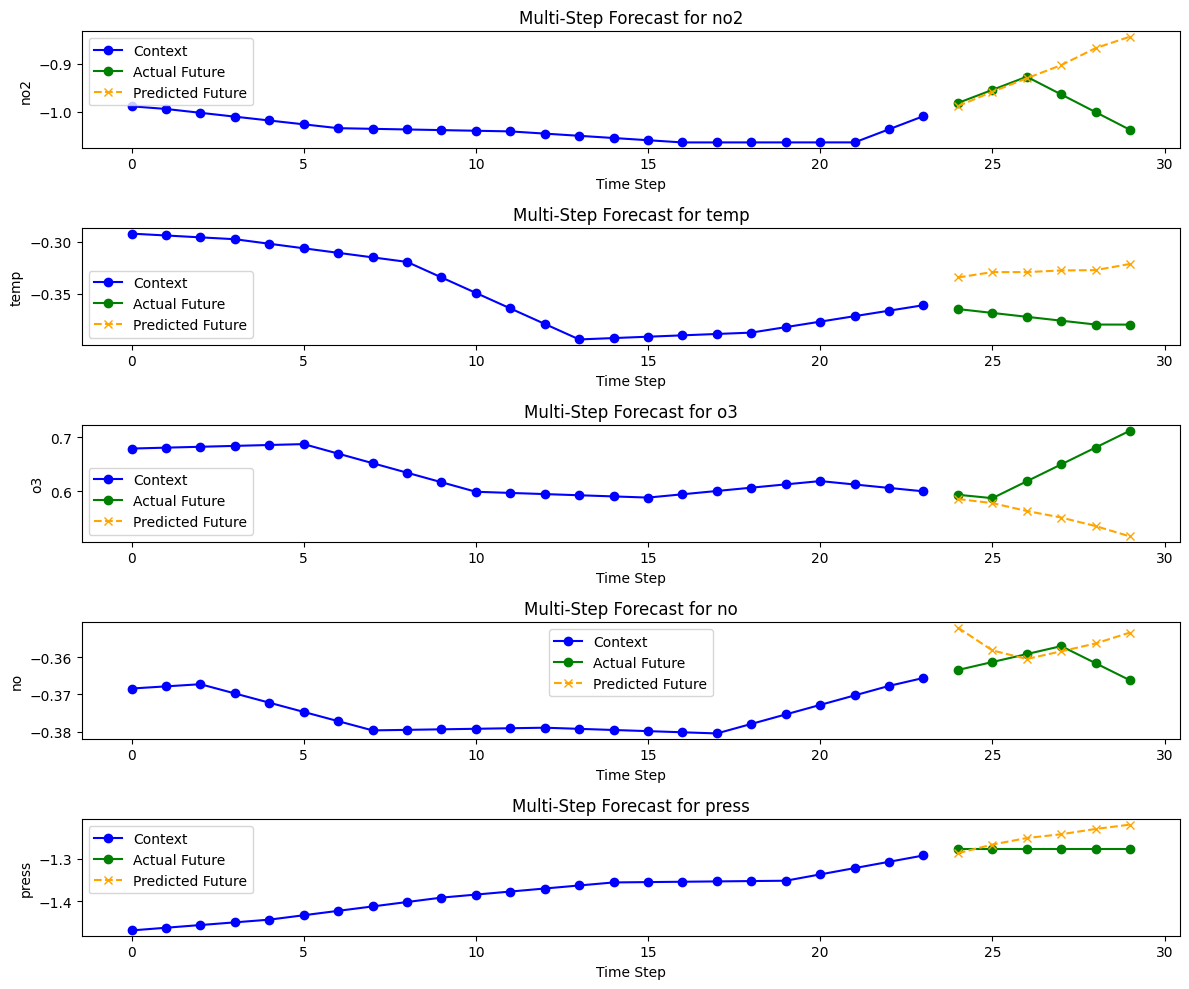

In [ ]:
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_columns):
    plt.subplot(len(variable_columns), 1, var_idx + 1)

    # Extract data for the last sample
    context = X_test[-1, :, var_idx]
    actual_future = y_test_actual[-1, :, var_idx]
    predicted_future = lstm_predictions[-1, :, var_idx]

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


#### One Step ahead prediction

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/11_zb9YCUZRF_CifbrUhY67jyiXXsMbH3/view?usp=sharing
checkpoint_dir = "./lstm_one_step_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_columns):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_columns)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, 0, var_idx]

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_one_step_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(1)
        ])

        lstm_model.compile(optimizer=lstm_optim, loss=lstm_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single.reshape(-1, 1),
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model
lstm_predictions = np.zeros((y_test.shape[0], len(variable_columns)))
y_test_actual = np.zeros((y_test.shape[0], len(variable_columns)))

scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}

# Predict
for var_idx, col in enumerate(variable_columns):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1)).flatten()
    lstm_predictions[:, var_idx] = lstm_pred_single

    # Inverse transform predictions and actual values
    lstm_predictions[:, var_idx] = (
        lstm_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[:, 0, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )


In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[ :, var_idx]
    y_pred_single = lstm_predictions[ :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.0305
Variable temp:
RMSE: 0.0156
Variable o3:
RMSE: 0.0288
Variable no:
RMSE: 0.0300
Variable press:
RMSE: 0.0097


In [ ]:
lstm_rolling_predictions = np.zeros((prediction_horizon, len(variable_columns)))
y_test_actual = np.zeros((prediction_horizon, len(variable_columns)))

# Select the last sample from the test set
X_test_single = X_test_lstm[-1]

for var_idx, col in enumerate(variable_columns):
    X_test_var = X_test_single[:, var_idx].reshape(1, context_window, 1)

    for step in range(prediction_horizon):
        lstm_pred_single = lstm_models[col].predict(X_test_var)

        lstm_rolling_predictions[step, var_idx] = lstm_pred_single[0, 0]

        # Shift the window and append the new prediction
        X_test_var = np.roll(X_test_var, shift=-1, axis=1)
        X_test_var[0, -1, 0] = lstm_pred_single

    # Inverse scale the predictions and actual values for the current variable
    lstm_rolling_predictions[:, var_idx] = (
        lstm_rolling_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[-1, :prediction_horizon, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-13-7beee5a3ed5e>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test_var[0, -1, 0] = lstm_pred_single


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

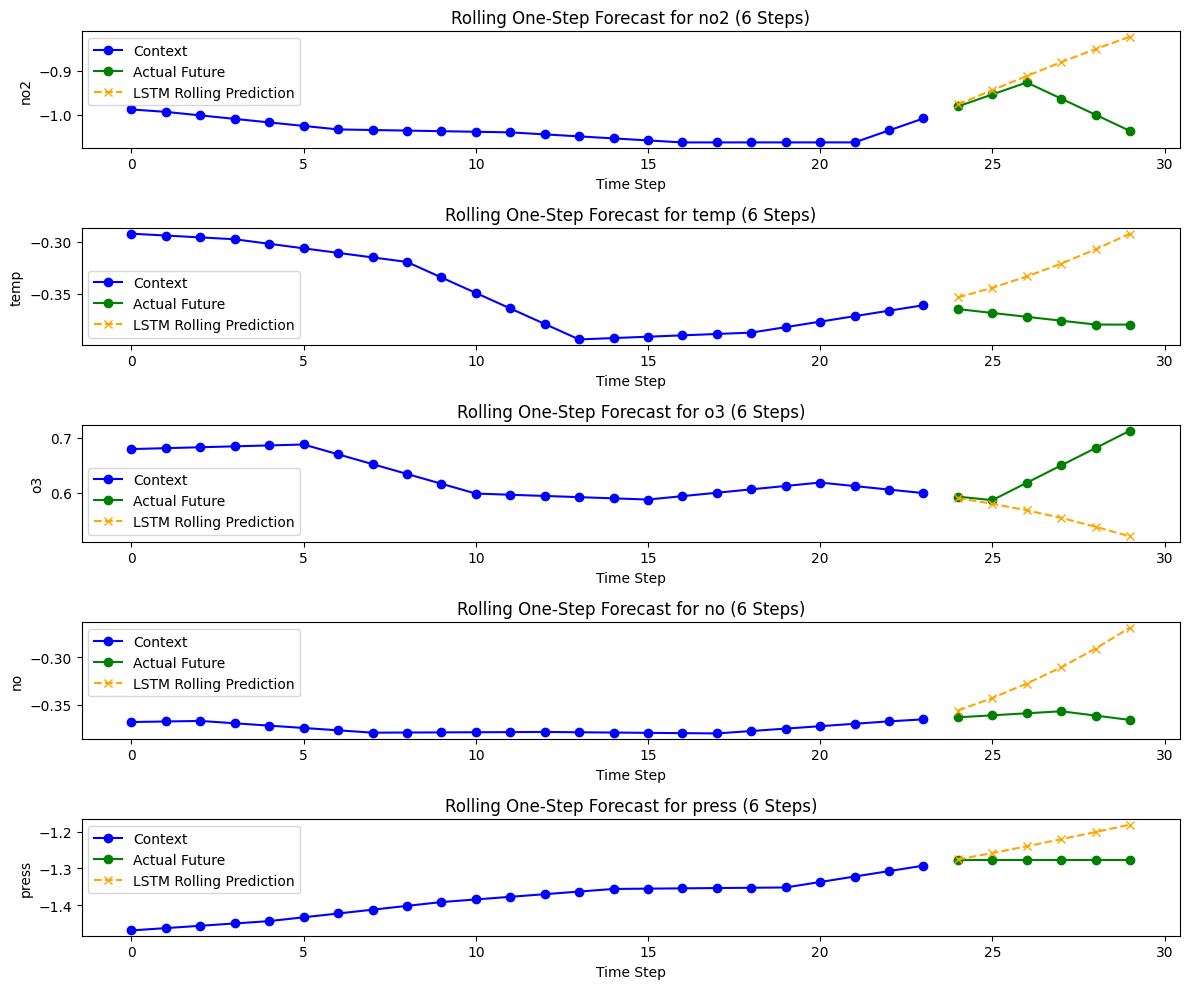

In [ ]:
# Plot Rolling One-Step-Ahead Forecast for All Variables (for the last sample)
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_columns):
    plt.subplot(len(variable_columns), 1, var_idx + 1)

    context = X_test_lstm[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    actual_future = y_test_actual[:, var_idx]
    predicted_future = lstm_rolling_predictions[:, var_idx]

    # Plot context window
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), actual_future,
             label="Actual Future", color="green", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future,
             label="LSTM Rolling Prediction", color="orange", linestyle="--", marker="x")

    plt.title(f"Rolling One-Step Forecast for {col} ({prediction_horizon} Steps)")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

### Forecasting with Transformers experimental

> Add blockquote


#### Housekeeping: setup and initial methods

In [ ]:
!pip install tensorflow numpy pandas matplotlib

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Input
from tensorflow.keras.models import Model

In [ ]:
# Set Hyperparameters
context_window = 24
prediction_horizon = 6
NUM_TRANSFORMER_BLOCKS = 3
NUM_HEADS = 4
FF_DIM = 128
DROPOUT = 0.1
FILTERS = 64
KERNEL_SIZE = 3
BATCH_SIZE = 32
EPOCHS = 5
activation_fn = "relu"
optimizer_fn = "adam"
loss_fn = "mse"
num_variables = len(variable_columns)

#### Model Prep

In [ ]:
def transformer_block(x, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout=DROPOUT):
    """Transformer Encoder Block."""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation=activation_fn)(out1)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)

    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


def build_exp_model():
    input_layer = Input(shape=(context_window, 1))
    x = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, padding="same", activation=activation_fn)(input_layer)

    for _ in range(NUM_TRANSFORMER_BLOCKS):
        x = transformer_block(x)

    x = Flatten()(x)
    output_layer = Dense(prediction_horizon)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer_fn, loss=loss_fn)
    return model

transformer_model = build_exp_model()

transformer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 24, 64)         │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 64)         │         66,368 │ conv1d[0][0],          │
│ (MultiHeadAttention)      │                        │                │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 64)         │              0 │ conv1d[0][0],          │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 24, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 24, 64)         │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 24, 64)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 24, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 259,078 (1012.02 KB)

 Trainable params: 259,078 (1012.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Univariate : Transformer

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
#
checkpoint_dir = "./transformer_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

transformer_models = {}
history_dict = {}
predictions = {}

for var in variable_columns:
    print(f"\nTraining transformer for variable: {var}")

    checkpoint_path = os.path.join(checkpoint_dir, f"transformer_{var}.h5")
    X_train_univariate = X_train[:, :, variable_columns.index(var)]
    X_test_univariate = X_test[:, :, variable_columns.index(var)]

    X_train_univariate = np.expand_dims(X_train_univariate, axis=-1)
    X_test_univariate = np.expand_dims(X_test_univariate, axis=-1)

    y_train_univariate = y_train[:, :, variable_columns.index(var)]
    y_test_univariate = y_test[:, :, variable_columns.index(var)]

    # Check if the model weights already exist
    if os.path.exists(checkpoint_path):
        print(f"Loading model weights for variable {var} from {checkpoint_path}")

        # Rebuild the model architecture first
        transformer_model = build_transformer_model()

        # Load the model weights
        transformer_model.load_weights(checkpoint_path)
        ## Notice how we don't load the model from checkpoint here unlike in previous cases,
        # as this .h5 only stores the weights and doesn't have the architecture info saved in it by design
        # Previous cases use in built tensorflow functions directly to create the models
        # However this model had to be defined using above custom structure.

    else:
        print(f"Training new model for variable {var}")

        transformer_model = build_transformer_model()

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train the model
        history = transformer_model.fit(
            X_train_univariate, y_train_univariate,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(X_test_univariate, y_test_univariate), verbose=1,
            callbacks=[checkpoint_callback]
        )

        history_dict[var] = history

    transformer_models[var] = transformer_model

    # Predict
    y_pred_univariate = transformer_model.predict(X_test_univariate)

    # Rescale back to original values
    mean, std = np.mean(dataframes[var]), np.std(dataframes[var])
    y_test_actual = (y_test_univariate * std) + mean
    y_pred_actual = (y_pred_univariate * std) + mean

    predictions[var] = (y_test_actual, y_pred_actual)


Training PatchTST for variable: no2
Loading model weights for variable no2 from ./patchtst_checkpoints/patchtst_no2.h5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 133s 30ms/step

Training PatchTST for variable: temp
Loading model weights for variable temp from ./patchtst_checkpoints/patchtst_temp.h5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 132s 30ms/step

Training PatchTST for variable: o3
Loading model weights for variable o3 from ./patchtst_checkpoints/patchtst_o3.h5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 131s 30ms/step

Training PatchTST for variable: no
Loading model weights for variable no from ./patchtst_checkpoints/patchtst_no.h5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 125s 28ms/step

Training PatchTST for variable: press
Loading model weights for variable press from ./patchtst_checkpoints/patchtst_press.h5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 124s 28ms/step


In [ ]:
for var in variable_columns:
    y_test_single = predictions[var][0]
    y_pred_single = predictions[var][1]

    print(f"Variable {var}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.1478
Variable temp:
RMSE: 0.0621
Variable o3:
RMSE: 0.1396
Variable no:
RMSE: 0.1345
Variable press:
RMSE: 0.0754


In [ ]:
# Plot results
plt.figure(figsize=(12, 10))
sample_idx=-1 # Last sample
for var_idx, var in enumerate(variable_columns):
    plt.subplot(len(variable_columns), 1, var_idx + 1)

    # Get last test sample
    X_test_sample = X_test[sample_idx, :, var_idx]
    y_test_sample, y_pred_sample = predictions[var]
    y_test_last = y_test_sample[sample_idx]  # shape (6,)
    y_pred_last = y_pred_sample[sample_idx]  # shape (6,)

    # Inverse scale the context
    mean = scaler_stats[var]['mean']
    std = scaler_stats[var]['std']
    context = X_test_sample * std + mean

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(range(context_window, context_window + prediction_horizon),
             y_test_last, label="Actual Future", color="green", marker="o")

    # Plot predicted future
    plt.plot(range(context_window, context_window + prediction_horizon),
             y_pred_last, label="transformer Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"transformer Forecast for {var}")
    plt.xlabel("Time Step")
    plt.ylabel(var)
    plt.legend()

plt.tight_layout()
plt.show()

# Conclusion and Future work

You may want to download stations not used in training to actual testing on the models above to assess the performance comparison on general data, the plots are only on validation data. Also attempt multivariate long range forecasting using the above architectures to see how well or bad they perform in comparison